In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Testing The Bowyer Watson Algorithm for triangulation

In [2]:
%load_ext Cython

------
------
Now for a plot
------
------



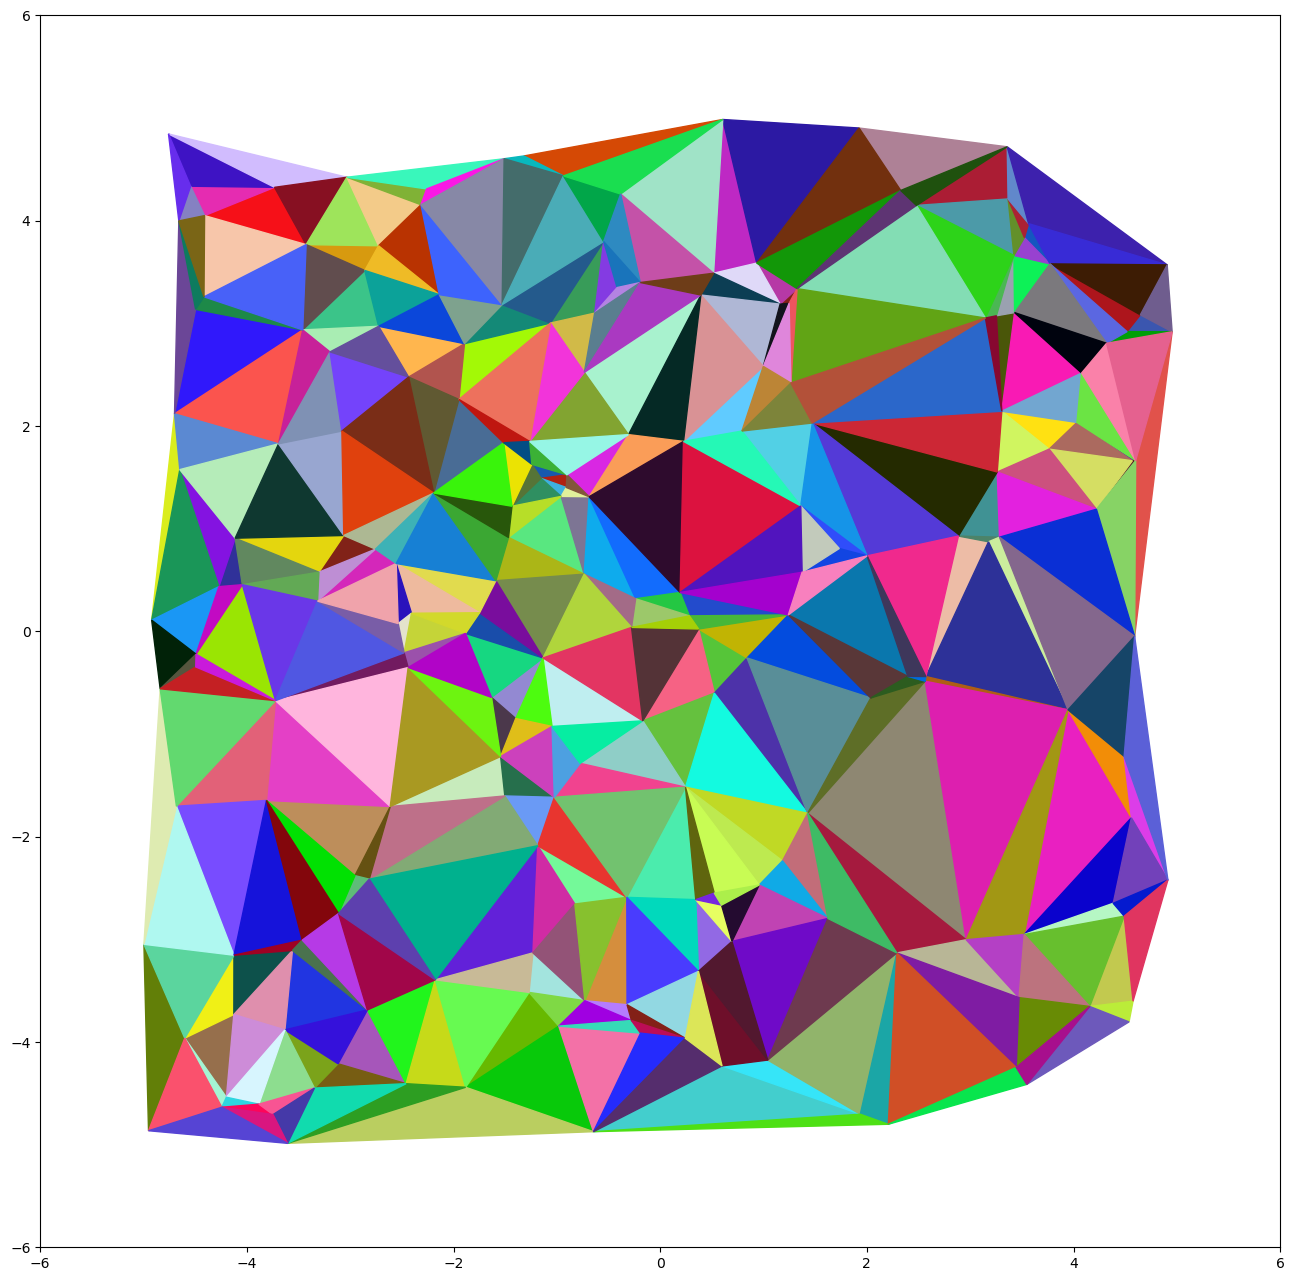

In [3]:
%%cython
cimport cython
from libc.stdlib cimport malloc, free
from cython cimport sizeof, NULL
from libc.math cimport sqrt






###########################


###########################
"""First layer simplex. The Vertex"""
"""Below functions to create an instance of the struct"""
ctypedef struct Vertex:
    double x
    double y
    int vid_nr

    


cdef Vertex create_vertex(double x_coord, double y_coord, int vid_number):
    cdef Vertex v
    v.x = x_coord
    v.y = y_coord
    v.vid_nr = vid_number
    return v





##
"""The Face"""
"""Functions to create instances of Face"""
ctypedef struct Face:
    Vertex ver1
    Vertex ver2
    Vertex ver3
    int fid_nr


    

cdef Face create_face(Vertex vertex1, Vertex vertex2, Vertex vertex3, int fid_number):
    cdef Face f
    f.ver1 = vertex1
    f.ver2 = vertex2
    f.ver3 = vertex3
    f.fid_nr = fid_number
    return f







###########################


###########################
"""Below functions for dynamic allocation purposes"""
###########################


###########################



"""deallocates and moves all elements under the removed index 1 upward"""
#works
@cython.boundscheck(False)
@cython.wraparound(False)
cdef Vertex* dealloc_from_varray(Vertex* original_array, int current_size, int remove_index):
    #careful remove_index is actual position - 1

    cdef Vertex* new_array = <Vertex*>malloc((current_size-1) * sizeof(Vertex))
    cdef int i
    cdef int j
    cdef int upper_limit = remove_index
    for i in range(upper_limit):
        new_array[i] = original_array[i]
    for j in range(upper_limit+1, current_size):
        new_array[j-1] = original_array[j]
        
    free(original_array)

    
    return new_array
        


"""A function like the one below to realloc a vertex array instead of a face array"""
#works
@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline Vertex* realloc_to_varray(Vertex* old_array, int current_size, Vertex new_vertex):
    cdef int new_size = current_size + 1
    cdef Vertex* new_array = <Vertex*>malloc(new_size * sizeof(Vertex))
    cdef int i
    for i in range(current_size):
        new_array[i] = old_array[i]
    new_array[current_size] = new_vertex
    
    free(old_array)

    return new_array



"""A function that takes a pointer to an array of Face structs. It creates a new array 1 size larger."""
"""It then appends the -new face- to it. Returns the new array. Frees the old one from memory"""
"""ATTENTION!!::: THE FACE* MESH INPUT MUST BE A MALLOC'ED ARRAY OR A POINTER TO A STATICALLY DECLARED ONE BY REFERENCING"""
#works
@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline Face* realloc_to_mesh(Face* mesh, int current_size, Face new_face):
    cdef int new_size = current_size + 1
    cdef Face* new_mesh = <Face*>malloc(new_size * sizeof(Face))
    cdef int i
    for i in range(current_size):
        new_mesh[i] = mesh[i]
    new_mesh[current_size] = new_face
    free(mesh)

    return new_mesh


"""Removes a Face in a mesh of a certain index"""
#works
@cython.boundscheck(False)
@cython.wraparound(False)
cdef Face* dealloc_from_mesh(Face* original_mesh, int current_size, int remove_index):

    cdef Face* new_mesh = <Face*>malloc((current_size-1) * sizeof(Face))
    cdef int i
    cdef int j
    cdef int upper_limit = remove_index
    for i in range(upper_limit):
        new_mesh[i] = original_mesh[i]
    for j in range(upper_limit+1, current_size):
        new_mesh[j-1] = original_mesh[j]
    free(original_mesh)

    
    return new_mesh




""""""###
"""A function to jumptstart allocate the Vertex struct in an array for testing purposes"""
#works
@cython.boundscheck(False)
@cython.wraparound(False)
cdef Vertex* alloc_varr(int size, double var):
    cdef Vertex* varray = <Vertex*>malloc(size * sizeof(Vertex))
    cdef int i
    for i in range(size):
        varray[i] = create_vertex(var, var, i)
    return varray

############################

"""Below functions for useful geometrical comparisons"""

############################




"""return magnitude of vector"""
#works
cdef inline double magnitude(double x, double y):
    return sqrt(x*x+y*y)



"""return dot product with respect to origin"""
#works
cdef inline double dot_product(Vertex v1, Vertex v2):
    return v1.x * v2.x + v1.y * v2.y



"""Distance between vertices"""
#works

@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline double distance(Vertex v1, Vertex v2):
    return sqrt((v1.x - v2.x)**2 + (v1.y - v2.y)**2)



"""Circumcenter"""
#works

#input 3 vertexes to calculate circumcenter of circumcircle
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cdef inline Vertex circumcenter(Vertex v1, Vertex v2, Vertex v3):
    cdef Vertex center
    #inverse of determinant method (by wedge product)
    cdef double D = (v1.x*(v2.y-v3.y) + v2.x*(v3.y-v1.y) + v3.x*(v1.y-v2.y))*2
    center.x = (1/D)*((v1.x**2 + v1.y**2)*(v2.y-v3.y) + (v2.x**2 + v2.y**2)*(v3.y-v1.y) + (v3.x**2 + v3.y**2)*(v1.y-v2.y))
    center.y = (1/D)*((v1.x**2 + v1.y**2)*(v3.x-v2.x) + (v2.x**2 + v2.y**2)*(v1.x-v3.x) + (v3.x**2 + v3.y**2)*(v2.x-v1.x))
    center.vid_nr = -1
    return center


"""Circumradius"""
#works

#you have to be retarded to not know what this returns
@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline double circumradius(Vertex v1, Vertex v2, Vertex v3):
    cdef Vertex ccenter = circumcenter(v1, v2, v3)
    cdef double radius = sqrt((v1.x-ccenter.x)**2 + (v1.y-ccenter.y)**2)
    
    return radius



"""Check if Vertex p is in Circumcircle of v1v2v3"""
#works

#returns 0 or 1 based on condition if p is in C(v)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline int in_circumcircle(Face f, Vertex p):
    cdef Vertex c_center = circumcenter(f.ver1, f.ver2, f.ver3)
    cdef double c_radius = circumradius(f.ver1, f.ver2, f.ver3)
    cdef double distance_from_circumcenter = distance(c_center, p)
    return distance_from_circumcenter < c_radius




"""Create the super Triangle"""
"""First create the max rectangle"""
"""Then set the triangle with sqrt3 formulas"""
#works

#return a pointer to a [3] array with 3 Vertex objects
@cython.boundscheck(False)
@cython.wraparound(False)
cdef Face create_super_triangle(Vertex* points, int num_points):
    cdef Face super_triangle
    
    cdef double min_x = points[0].x
    cdef double min_y = points[0].y
    cdef double max_x = points[3].x
    cdef double max_y = points[3].y

    cdef int i

    for i in range(num_points):
        if points[i].x < min_x:
            min_x = points[i].x

        if points[i].y < min_y:
            min_y = points[i].y
            
    for i in range(num_points):
        if points[i].x > max_x:
            max_x = points[i].x

        if points[i].y > max_y:
            max_y = points[i].y
            
    cdef double a = (max_x - min_x)
    cdef double b = (max_y - min_y)

    

    super_triangle.ver1.x = min_x + a*0.5
    super_triangle.ver1.y = max_y + a*0.5
    super_triangle.ver1.vid_nr = -1


    super_triangle.ver2.x = max_x + b
    super_triangle.ver2.y = min_y - 1
    super_triangle.ver2.vid_nr = -2


    super_triangle.ver3.x = min_x - b
    super_triangle.ver3.y = min_y - 1
    super_triangle.ver3.vid_nr = -3

    
    super_triangle.fid_nr = 0


    return super_triangle










"""The most important part to have valid faces with no crossings. It takes a list of free vertexes and oriens them c-clockwise"""
"""Uses the Dot product orthogonality and Bubble Sort"""
#works
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cdef inline void sort_by_angle_cclockwise(Vertex* free_vertexes, Vertex center_vertex, int size):
    cdef int vertexes_over_x_axis = 0
    cdef int vertexes_under_x_axis = 0
    ###  !DON'T FORGET TO FREE!  ###
    ###
    cdef Vertex* displaced_vertexes_overx = <Vertex*>malloc(sizeof(Vertex))
    cdef Vertex* displaced_vertexes_underx = <Vertex*>malloc(sizeof(Vertex))
    ###
    

    cdef double x_newcoord
    cdef double y_newcoord
    
    cdef int i
    
    for i in range(size):
        x_newcoord = free_vertexes[i].x - center_vertex.x
        y_newcoord = free_vertexes[i].y - center_vertex.y

        if y_newcoord >= 0.:
            displaced_vertexes_overx = realloc_to_varray(displaced_vertexes_overx, vertexes_over_x_axis, free_vertexes[i])
            vertexes_over_x_axis = vertexes_over_x_axis + 1
            
            
        elif y_newcoord < 0.:
            displaced_vertexes_underx = realloc_to_varray(displaced_vertexes_underx, vertexes_under_x_axis, free_vertexes[i])
            vertexes_under_x_axis = vertexes_under_x_axis + 1
        

    cdef int j
    cdef int k
    cdef int l
    cdef int p
    cdef Vertex tmp_vertex1
    cdef Vertex tmp_vertex2
    cdef double tmp_mag1
    cdef double tmp_mag2

    cdef double tmp_projection1
    cdef double tmp_projection2


    for j in range(vertexes_over_x_axis):
        for k in range(vertexes_over_x_axis-j-1):
            tmp_mag1 = magnitude((displaced_vertexes_overx[k].x-center_vertex.x), (displaced_vertexes_overx[k].y-center_vertex.y))
            tmp_mag2 = magnitude((displaced_vertexes_overx[k+1].x-center_vertex.x), (displaced_vertexes_overx[k+1].y-center_vertex.y))
            if tmp_mag1 == 0.:
                return
            elif tmp_mag2 == 0.:
                return
            
            
            tmp_projection1 = (displaced_vertexes_overx[k].x-center_vertex.x)/tmp_mag1
            tmp_projection2 = (displaced_vertexes_overx[k+1].x-center_vertex.x)/tmp_mag2

            if tmp_projection1 <= tmp_projection2:
                tmp_vertex1 = displaced_vertexes_overx[k]
                displaced_vertexes_overx[k] = displaced_vertexes_overx[k+1]
                displaced_vertexes_overx[k+1] = tmp_vertex1
                
    for l in range(vertexes_under_x_axis):
        for p in range(vertexes_under_x_axis-l-1):
            tmp_mag1 = (magnitude(displaced_vertexes_underx[p].x-center_vertex.x, displaced_vertexes_underx[p].y-center_vertex.y))
            tmp_mag2 = (magnitude(displaced_vertexes_underx[p+1].x-center_vertex.x, displaced_vertexes_underx[p+1].y-center_vertex.y))
            if tmp_mag1 == 0.:
                return
            elif tmp_mag2 == 0.:
                return
            
            
            tmp_projection1 = (displaced_vertexes_underx[p].x-center_vertex.x)/tmp_mag1
            tmp_projection2 = (displaced_vertexes_underx[p+1].x-center_vertex.x)/tmp_mag2


            if tmp_projection1 > tmp_projection2:
                tmp_vertex2 = displaced_vertexes_underx[p]
                displaced_vertexes_underx[p] = displaced_vertexes_underx[p+1]
                displaced_vertexes_underx[p+1] = tmp_vertex2
 
    cdef int m
    cdef int n
    for m in range(vertexes_over_x_axis):
        free_vertexes[m] = displaced_vertexes_overx[m]
    

    for n in range(vertexes_over_x_axis, size):
        free_vertexes[n] = displaced_vertexes_underx[n-vertexes_over_x_axis]

 
    free(displaced_vertexes_overx)
    free(displaced_vertexes_underx)
#end function




    
    
    
    

#SUPER EXPERIMENTAL
@cython.boundscheck(False)
@cython.wraparound(False)
cdef Face* triangulate(Vertex* original_array, int varr_size, int* gm_size):
    
    cdef Face* final_mesh = <Face*>malloc(sizeof(Face))
    cdef int final_mesh_size = 0
    
    cdef Face* bad_mesh = <Face*>malloc(sizeof(Face))
    cdef Vertex* free_vertices = <Vertex*>malloc(sizeof(Vertex))
    cdef int bad_mesh_size = 0
    cdef int free_vertices_size = 0

    cdef Face temp_face
    cdef Face super_triangle = create_super_triangle(original_array, varr_size)
    
    final_mesh = realloc_to_mesh(final_mesh, final_mesh_size, super_triangle)
    final_mesh_size = final_mesh_size + 1


    cdef int q, r, i, k, l, m, s
    for r in range(varr_size): #main loop

        q = 0
        
        while True:
            if q == final_mesh_size:
                break
            if in_circumcircle(final_mesh[q], original_array[r]):
                bad_mesh = realloc_to_mesh(bad_mesh, bad_mesh_size, final_mesh[q])
                bad_mesh_size = bad_mesh_size + 1
                final_mesh = dealloc_from_mesh(final_mesh, final_mesh_size, q)
                final_mesh_size = final_mesh_size - 1
            else:
                q = q + 1

        for i in range(bad_mesh_size):
            free_vertices = realloc_to_varray(free_vertices, free_vertices_size, bad_mesh[i].ver1)
            free_vertices_size = free_vertices_size + 1
            free_vertices = realloc_to_varray(free_vertices, free_vertices_size, bad_mesh[i].ver2)
            free_vertices_size = free_vertices_size + 1
            free_vertices = realloc_to_varray(free_vertices, free_vertices_size, bad_mesh[i].ver3)
            free_vertices_size = free_vertices_size + 1

        for n in range(bad_mesh_size):
            bad_mesh = dealloc_from_mesh(bad_mesh, bad_mesh_size, 0)
        bad_mesh_size = 0

        k=0
        while k < free_vertices_size - 1:
            l = k + 1
            while l < free_vertices_size:
                if free_vertices[l].vid_nr == free_vertices[k].vid_nr:
                    free_vertices = dealloc_from_varray(free_vertices, free_vertices_size, l)
                    free_vertices_size = free_vertices_size - 1
                else:
                    l = l + 1
            k = k + 1

        sort_by_angle_cclockwise(free_vertices, original_array[r], free_vertices_size)

        for m in range(free_vertices_size):
            temp_face = create_face(original_array[r], free_vertices[m], free_vertices[(m+1)%free_vertices_size], 0)
            final_mesh = realloc_to_mesh(final_mesh, final_mesh_size, temp_face)
            final_mesh_size = final_mesh_size + 1
            
        for s in range(free_vertices_size):
            free_vertices = dealloc_from_varray(free_vertices, free_vertices_size, 0)
        free_vertices_size = 0

    cdef int index = 0

    while True:
        if index == final_mesh_size:
            break
        
        if final_mesh[index].ver1.vid_nr < 0 or final_mesh[index].ver2.vid_nr < 0 or final_mesh[index].ver3.vid_nr < 0:
            final_mesh = dealloc_from_mesh(final_mesh, final_mesh_size, index)
            final_mesh_size = final_mesh_size - 1

        else:
            index = index + 1

    cdef int z
    
    for z in range(final_mesh_size):
        final_mesh[z].fid_nr = z
        
    gm_size[0] = final_mesh_size
        
    return final_mesh
        

    
#########################################################################################
#########################################################################################
"""TEST UNITS"""
#########################################################################################
#########################################################################################

import random
import matplotlib.pyplot as plt
    

"""unit test for angular sorting and using the dealloc functions on a mesh and varray"""
#start the array of Zero-Zero Vertices
#!! THIS ARRAY IS MALLOCED BUT NOT FREED BY DEFAULT !! THE SIZE HAS TO BE KEPT TRACK OF
cdef int varr_ssize = 200
cdef Vertex* og_array = alloc_varr(varr_ssize, 0)
cdef int* global_mesh_size = <int*>malloc(sizeof(int))
global_mesh_size[0] = 0 #dynamically changed through triangulate fx


for f in range(varr_ssize):
    og_array[f].x = random.uniform(-5, 5)
    og_array[f].y = random.uniform(-5, 5)




cdef Face* testmesh = triangulate(og_array, varr_ssize, global_mesh_size)



    
    
    
print("------\n------\nNow for a plot\n------\n------\n")



plt.figure(figsize = (16, 16))
def random_color():
    return "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))



# Set custom x and y axis limits
plt.xlim(-6, 6)
plt.ylim(-6, 6)


for f in range(global_mesh_size[0]):
    plt.fill((testmesh[f].ver1.x, testmesh[f].ver2.x, testmesh[f].ver3.x, testmesh[f].ver1.x), (testmesh[f].ver1.y, testmesh[f].ver2.y, testmesh[f].ver3.y, testmesh[f].ver1.y), color=random_color())






plt.show()
free(testmesh)
free(og_array)
free(global_mesh_size)












In [ ]:
##test unit for mesh plot

cdef Face f1 = create_face(vertex_array[0], vertex_array[1], vertex_array[2], 0)
cdef Face f2 = create_face(vertex_array[1], vertex_array[2], vertex_array[3], 1)
cdef Face f3 = create_face(vertex_array[1], vertex_array[3], vertex_array[6], 2)


cdef int mesh_size = 0

mesh = realloc_to_mesh(mesh, mesh_size, f1)
mesh_size = mesh_size + 1
mesh = realloc_to_mesh(mesh, mesh_size, f2)
mesh_size = mesh_size + 1
mesh = realloc_to_mesh(mesh, mesh_size, f3)
mesh_size = mesh_size + 1


print("\nmesh size is:", mesh_size,"\n")


print(mesh[0],"\n")
print(mesh[1],"\n")
print(mesh[2],"\n")



# Extract x and y coordinates for each vertex of both triangles
  # Add the first vertex at the end to close the triangle
x_coords_triangle1 = [mesh[0].ver1.x, mesh[0].ver2.x, mesh[0].ver3.x, mesh[0].ver1.x]
y_coords_triangle1 = [mesh[0].ver1.y, mesh[0].ver2.y, mesh[0].ver3.y, mesh[0].ver1.y] 


x_coords_triangle2 = [mesh[1].ver1.x, mesh[1].ver2.x, mesh[1].ver3.x, mesh[1].ver1.x]
y_coords_triangle2 = [mesh[1].ver1.y, mesh[1].ver2.y, mesh[1].ver3.y, mesh[1].ver1.y] 


x_coords_triangle3 = [mesh[2].ver1.x, mesh[2].ver2.x, mesh[2].ver3.x, mesh[2].ver1.x]
y_coords_triangle3 = [mesh[2].ver1.y, mesh[2].ver2.y, mesh[2].ver3.y, mesh[2].ver1.y] 


# Plot both triangles
fig, ax = plt.subplots()
triangle1 = patches.Polygon(xy=list(zip(x_coords_triangle1, y_coords_triangle1)), closed=True, facecolor='lightblue', edgecolor='black')
triangle2 = patches.Polygon(xy=list(zip(x_coords_triangle2, y_coords_triangle2)), closed=True, facecolor='lightgreen', edgecolor='black')
triangle3 = patches.Polygon(xy=list(zip(x_coords_triangle3, y_coords_triangle3)), closed=True, facecolor='red', edgecolor='black')
ax.add_patch(triangle1)
ax.add_patch(triangle2)
ax.add_patch(triangle3)

# Calculate the center of each triangle
center_x_triangle1 = sum(x_coords_triangle1) / 3.0
center_y_triangle1 = sum(y_coords_triangle1) / 3.0

center_x_triangle2 = sum(x_coords_triangle2) / 3.0
center_y_triangle2 = sum(y_coords_triangle2) / 3.0

center_x_triangle3 = sum(x_coords_triangle3) / 3.0
center_y_triangle3 = sum(y_coords_triangle3) / 3.0

# Add labels "1" and "2" at the centers of the triangles
ax.text(center_x_triangle1, center_y_triangle1, "f1", fontsize=12, ha='center', va='center')
ax.text(center_x_triangle2, center_y_triangle2, "f2", fontsize=12, ha='center', va='center')
ax.text(center_x_triangle3, center_y_triangle3, "f3", fontsize=12, ha='center', va='center')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Three Triangles')
ax.grid(False)
plt.axis('equal')  # Set aspect ratio to be equal
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the vertices of the first triangle (x, y coordinates)
vertex1 = (0, 0)
vertex2 = (3, 4)
vertex3 = (6, 0)

# Define the vertices of the second triangle (x, y coordinates)
vertex4 = (7, 3)

# Extract x and y coordinates for each vertex of both triangles
x_coords_triangle1 = [vertex1[0], vertex2[0], vertex3[0], vertex1[0]]  # Add the first vertex at the end to close the triangle
y_coords_triangle1 = [vertex1[1], vertex2[1], vertex3[1], vertex1[1]]

x_coords_triangle2 = [vertex2[0], vertex3[0], vertex4[0], vertex2[0]]  # Add the first vertex at the end to close the triangle
y_coords_triangle2 = [vertex2[1], vertex3[1], vertex4[1], vertex2[1]]

# Plot both triangles
fig, ax = plt.subplots()
triangle1 = patches.Polygon(xy=list(zip(x_coords_triangle1, y_coords_triangle1)), closed=True, facecolor='lightblue', edgecolor='blue')
triangle2 = patches.Polygon(xy=list(zip(x_coords_triangle2, y_coords_triangle2)), closed=True, facecolor='lightgreen', edgecolor='green')
ax.add_patch(triangle1)
ax.add_patch(triangle2)

# Calculate the center of each triangle
center_x_triangle1 = sum(x_coords_triangle1) / 3.0
center_y_triangle1 = sum(y_coords_triangle1) / 3.0

center_x_triangle2 = sum(x_coords_triangle2) / 3.0
center_y_triangle2 = sum(y_coords_triangle2) / 3.0

# Add labels "1" and "2" at the centers of the triangles
ax.text(center_x_triangle1, center_y_triangle1, "1", fontsize=12, ha='center', va='center')
ax.text(center_x_triangle2, center_y_triangle2, "2", fontsize=12, ha='center', va='center')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Two Triangles')
ax.grid(True)
plt.axis('equal')  # Set aspect ratio to be equal
plt.show()
